# MCMC using backward filtering, forward guiding for shapes

Parameter inference for trees with Gaussian transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebook [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb) for a simpler version with $\mathbb R^2$ data, and [mcmc_Gaussian_BFFG_shapes.ipynb](mcmc_Gaussian_BFFG_shapes.ipynb) for a version with constant covariance and thus a fully Gaussian model. In this notebook, the node covariance is shape depedent, thus requiring computation of likelihood ratios in the downwards passes for use in the MCMC iterations.

The covariance is assumed rotationally invariant, allowing factorization into a kernel product the identity matrix of the ambient space.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example. The notation, likelihood ratio calculation etc. follow https://arxiv.org/abs/2203.04155 section 6.1.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

from examples.ABFFG import *
from examples.shape import k_K2

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# seed,
#seed = 42
import os; seed = int(os.urandom(5).hex(), 16)
print("seed: ",seed)
key = PRNGKey(seed)

seed:  858959100264


# Shape related setup

<Axes: >

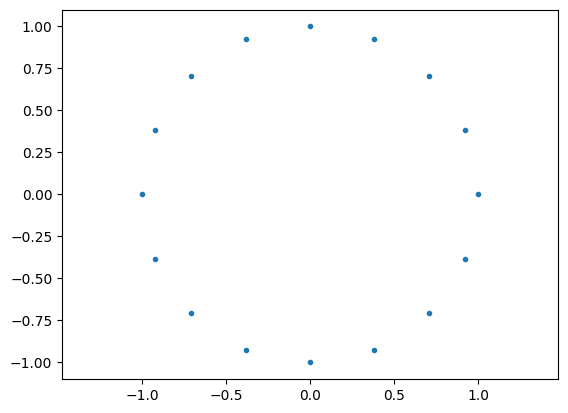

In [4]:
# define shape and plot
d = 2; n = 16 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape_2d(root)

In [5]:
# diffusion and covariance specification for shape processes
# This version assumes same covariance in all directions (x,y or x,y,z), thus allowing some factorization of the covariance matrix

kQ12 = lambda x,params: (1/n)*k_K2(x,params)

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# diffusion field and covariance matrix factored in dimensions
sigma = lambda q,theta: kQ12_q(q,q,theta) # diffusion field, kernel evaluated on all landmark pairs
def a(q,theta): sigmaq = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmaq,sigmaq) # covariance

# Gaussian tree, node-dependent covariance

First, we initialize the tree. We set the root to the shape defined above.

In [6]:
# create topology and tree
topology = symmetric_topology(height=2, degree=5)
plot_tree_text(topology)
tree = HypTree(topology)
print(tree)

# add properties to tree
tree.add_property('edge_length', shape=())
# data dimension
d = 2
tree.add_property('value', shape=(n*d,))
tree.add_property('noise', shape=(n*d,))

# set edge lengths on all nodes
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])

# root value
tree.data['value'] = tree.data['value'].at[0].set(root)

                                                            None
           ┌────────────────────────┬────────────────────────┼────────────────────────┬────────────────────────┐
          None                     None                     None                     None                     None          
 ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐  
None None None None None None None None None None None None None None None None None None None None None None None None None
HypTree(size=31, levels=3, leaves=25, inner nodes=5)


We then define parameters for the Gaussian transition kernel.

In [7]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.1), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions. At first, we define the unconditional transitions, which are just Gaussian samples. The covariance is square of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [8]:
# unconditional down
down_unconditional = Gaussian_down_unconditional(sigma)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [9]:
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

Add uncorrelated observation noise to leaves.



In [10]:
# add noise to leaf nodes
key, subkey = split(key)
add_leaf_noise(tree,key,params)
leaf_values = tree.data['value'][tree.is_leaf]

Plot a generated tree.

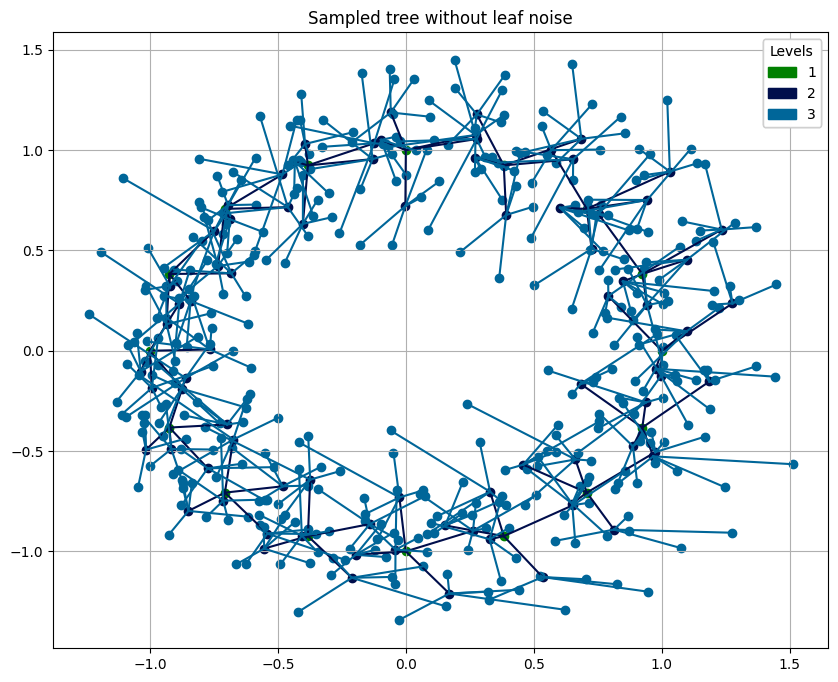

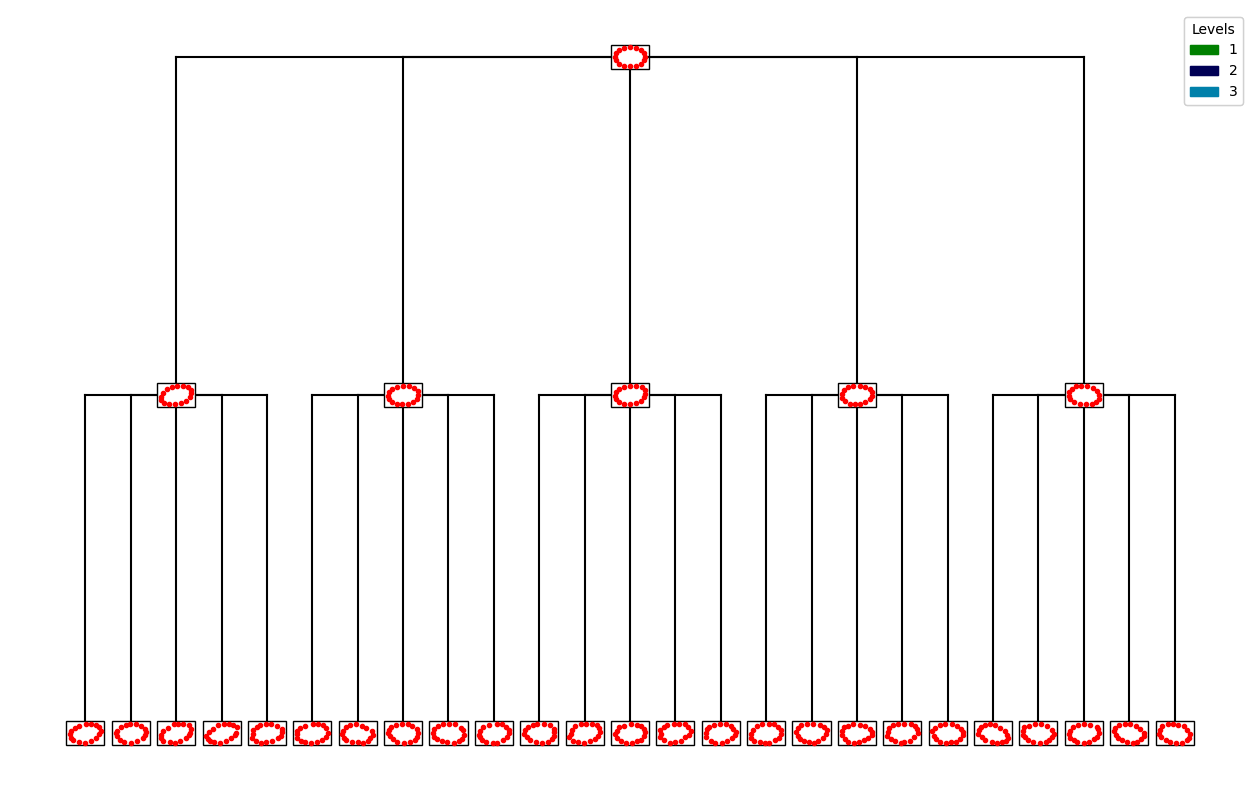

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((n,d)),ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_2d_shape(tree,'value')

# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [12]:
# backwards filter
up = Gaussian_up(n,a,d=d)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [13]:
# initialize tree
init_up = get_init_up(n,tree,d=d)

We can now define the conditional downwards pass, i.e. the forwards guiding.

In [14]:
# conditional down
down_conditional = Gaussian_down_conditional(n,a,d=d)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [15]:
# backwards filter and fowards guiding
test_up_down(down_unconditional,down_conditional,up,init_up,tree,params,leaf_values,key)

Time elapsed: 0.1428 ms
Time elapsed: 0.7710 ms
Time elapsed: 0.5863 ms


# MCMC

MCMC run incorporating the likelihood ratios arising from the Gaussian approximation.

Initial parameters:  {'k_alpha': 0.1, 'k_sigma': 0.1, 'obs_var': 0.001}
data parameters:  {'k_alpha': 0.1, 'k_sigma': 0.5, 'obs_var': 0.001}


100%|██████████| 2000/2000 [00:24<00:00, 81.74it/s]


Acceptance rate: 0.8460


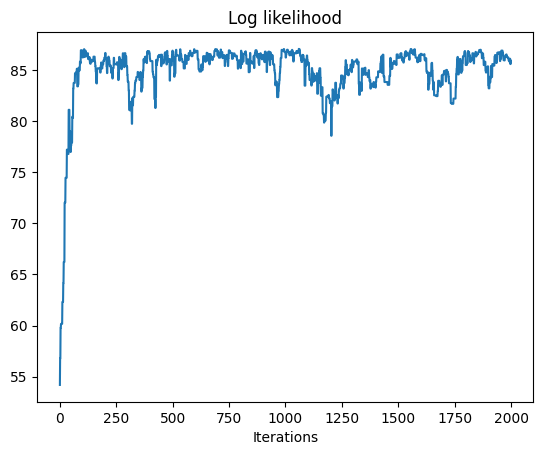

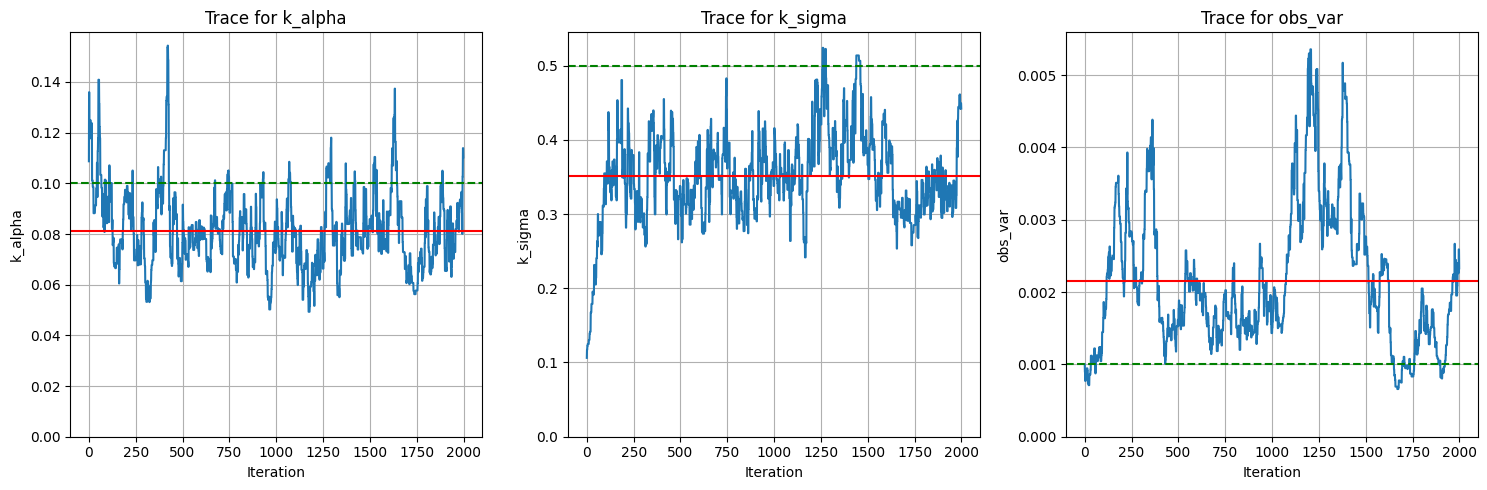

In [18]:
log_likelihood = get_log_likelihood(tree,down_conditional,up,init_up)
log_posterior = get_log_posterior(log_likelihood)
proposal = get_proposal(tree)

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.1,alpha=3,beta=.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.1), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,min=1e-4,max=.1,prior='uniform') # observation noise variance
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
init_state = (init_params,(jnp.zeros_like(tree.data['noise']),tree.data['v_T']))

# Run Metropolis-Hasting2
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 2000, burn_in=000, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples,params.values())